In [1]:
import torch
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
device = torch.device("cuda:0")

%load_ext autoreload
%autoreload 2

# support running without installing as a package
wd = Path.cwd().parent
sys.path.append(str(wd))

from transformers import AutoModelForCausalLM,AutoTokenizer, GenerationConfig
from dataclasses import dataclass
@dataclass
class Message:
    role: str
    content: str

In [2]:
from config import hf_cache_dir

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "tomg-group-umd/huginn-0125", torch_dtype=torch.bfloat16, trust_remote_code=True,
    cache_dir=hf_cache_dir).to(device)
ctrl_model = AutoModelForCausalLM.from_pretrained(
    "tomg-group-umd/step-00010720-baseline_2_0", torch_dtype=torch.bfloat16, trust_remote_code=True,
    cache_dir=hf_cache_dir).to(device)
ctrl_model.config.test_time_noise = 0
ctrl_model.config.test_time_noise_type = "fixed"
tokenizer = AutoTokenizer.from_pretrained("tomg-group-umd/huginn-0125")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [4]:
config = GenerationConfig(max_length=250, stop_strings=["<|end_text|>", "<|end_turn|>"], 
                          do_sample=False, temperature=None, top_k=None, top_p=None, min_p=None, 
                          return_dict_in_generate=True, use_cache=False,
                          eos_token_id=65505,bos_token_id=65504,pad_token_id=65509)
                          # Note: num_steps and other model arguments CANNOT be included here, they will shadow model args at runtime
from transformers import TextStreamer
streamer = TextStreamer(tokenizer) # type: ignore

In [48]:
prompt = "Munich is located in the country where the capital is "
answer = "Berlin"
country = "Germany"
other_countries = ["France", "Italy", "Spain", "Poland", "Sweden"]

In [9]:
n_steps = 32

In [23]:
def get_outputs(prompt, model, generation_steps):
    input_ids = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to(device)
    input_len = input_ids.shape[1]
    _generation_steps = generation_steps if generation_steps > 0 else 1
    config = GenerationConfig(max_new_tokens=_generation_steps,
                              stop_strings=["<|end_text|>", "<|end_turn|>"], 
                              use_cache=False,
                              do_sample=False, temperature=None, top_k=None, top_p=None, min_p=None, 
                              return_dict_in_generate=True,
                              eos_token_id=65505,bos_token_id=65504,pad_token_id=65509)
    outputs = model.generate(input_ids, config, tokenizer=tokenizer, num_steps=n_steps)
    if generation_steps == 0:
        outputs.sequences = outputs.sequences[:, :input_len]
    return outputs

In [26]:
@torch.no_grad()
def compute_latents(model, outputs, num_steps):
    # Get initial state and compute trajectory
    embedded_inputs, _ = model.embed_inputs(outputs.sequences)
    input_states = model.initialize_state(embedded_inputs)

    # Initialize storage for normalized latents
    latents = []
    current_latents = input_states
    latents.append(model.transformer.ln_f(current_latents).cpu().float().numpy())

    # Collect all latent states
    for step in range(num_steps):
        current_latents, _,_ = model.iterate_one_step(embedded_inputs, current_latents)
        normalized_latents = model.transformer.ln_f(current_latents)
        latents.append(normalized_latents.cpu().float().numpy())

    # Stack all latents
    latents = np.stack(latents).squeeze()  # [num_steps+1, batch, seq_len, hidden_dim]
    return latents

In [ ]:
prompt_outputs = get_outputs(prompt, model, generation_steps=4)
prompt_latents = compute_latents(model, prompt_outputs, num_steps=n_steps) # (n_steps, seq_len, hidden_dim)
print(tokenizer.decode(prompt_outputs.sequences[0]))

answer_outputs = get_outputs(answer, model, generation_steps=0)
answer_latents = compute_latents(model, answer_outputs, num_steps=n_steps)

country_outputs = get_outputs(country, model, generation_steps=0)
country_latents = compute_latents(model, country_outputs, num_steps=n_steps)

other_country_latents = []
for other_country in other_countries:
    other_country_outputs = get_outputs(other_country, model, generation_steps=0)
    other_country_latents.append(compute_latents(model, other_country_outputs, num_steps=n_steps))

<|begin_text|>Munich is located in the country where the capital is ​Berlin.


In [49]:
other_country_latents = []
for other_country in other_countries:
    other_country_outputs = get_outputs(other_country, model, generation_steps=0)
    other_country_latents.append(compute_latents(model, other_country_outputs, num_steps=n_steps))

In [43]:
P = prompt_latents[:,-1]
A = answer_latents[:,-1]
C = country_latents[:,-1]

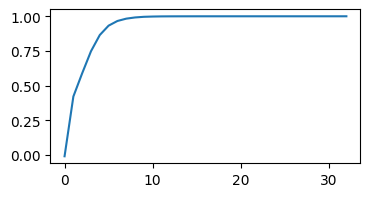

In [45]:
def get_correlations(M, v):
    # Normalize each timestep vector in M
    M_norm = M / np.linalg.norm(M, axis=1, keepdims=True)

    # Normalize v
    v_norm = v / np.linalg.norm(v)

    # Compute correlation (dot product) between each timestep and v
    correlations = np.dot(M_norm, v_norm)
    return correlations

correlations = get_correlations(A, A[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

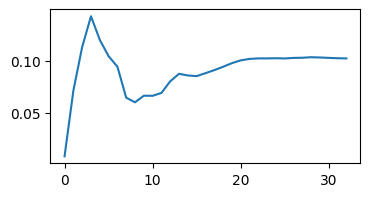

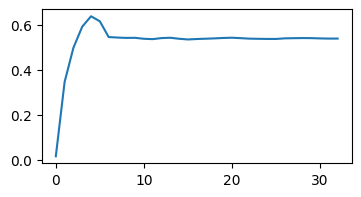

In [ ]:
correlations = get_correlations(P, A[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

correlations = get_correlations(prompt_latents[:,-2], A[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

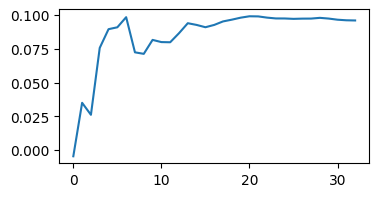

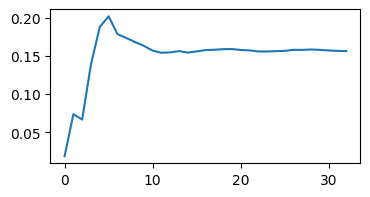

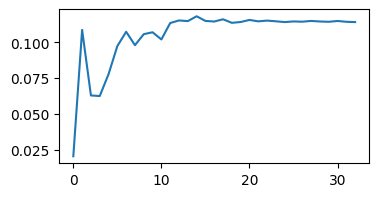

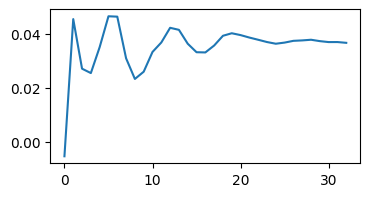

In [67]:
correlations = get_correlations(prompt_latents[:, -1], C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

correlations = get_correlations(prompt_latents[:, -2], C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

correlations = get_correlations(prompt_latents[:, -3], C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

correlations = get_correlations(prompt_latents[:, -4], C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

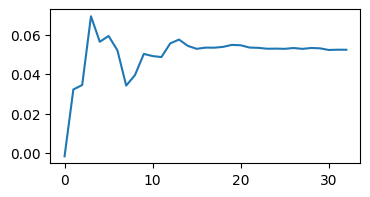

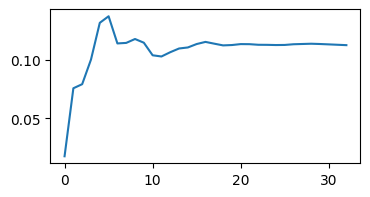

In [64]:
null_C = other_country_latents[2][:,-1] 
correlations = get_correlations(prompt_latents[:, -1], null_C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

correlations = get_correlations(prompt_latents[:, -2], null_C[-1])
plt.figure(figsize=(4,2))
plt.plot(correlations)
plt.show()

In [ ]:
pl = prompt_latents[:,-1]
c = country_latents[:,-1]

(5280,)

In [36]:
a.shape

(33, 5280)

In [39]:
# Normalize each timestep vector in a
a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)

# Normalize last_a
last_a_norm = last_a / np.linalg.norm(last_a)

# Compute correlation (dot product) between each timestep and last_a
correlations = np.dot(a_norm, last_a_norm)

correlations

array([-0.00874173,  0.4220296 ,  0.5893636 ,  0.74808717,  0.8650069 ,
        0.93248785,  0.9660353 ,  0.98285437,  0.99151945,  0.99615395,
        0.9980767 ,  0.99917716,  0.9995457 ,  0.9997163 ,  0.99980044,
        0.99986017,  0.99990225,  0.99990714,  0.9999109 ,  0.99992394,
        0.9999033 ,  0.9999248 ,  0.99991643,  0.999923  ,  0.9999138 ,
        0.9999243 ,  0.9999169 ,  0.99991894,  0.9999312 ,  0.99991965,
        0.99992615,  0.99993527,  1.0000004 ], dtype=float32)

In [ ]:
prompt_latents.shape

(33, 1, 15, 5280)

In [14]:
answer_latents.shape

(33, 1, 5, 5280)